# CardioRisk Advisor(CardioChat)

Step 1: Raw Input (Real-time)
-------------------------------
PPG Signal + Age, Sex, etc. → From camera or wearable

Step 2: Blood Pressure Estimation
----------------------------------
Your trained model predicts:
  → SBP (Systolic)
  → DBP (Diastolic)

Step 3: Heart Disease Risk Prediction
--------------------------------------
Another model uses:
  → Predicted SBP/DBP
  → Clinical info 
To predict:
  → Probability of Heart Disease

Step 4: Output via Web Interface
----------------------------------
UI shows:
  - Estimated BP (e.g., 125/80)
  - Heart disease risk (e.g., Moderate Risk: 64%)
  - Optional: Next steps (see a doctor, record again tomorrow, etc.)#

In [48]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from scipy import stats

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss, roc_curve, auc, RocCurveDisplay
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
medical_df = pd.read_csv("framingham.csv")
df = medical_df.copy()

In [3]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [4]:
for col in df.columns:
  print(f'unique({col}) = {len(df[col].unique())}')

unique(male) = 2
unique(age) = 39
unique(education) = 5
unique(currentSmoker) = 2
unique(cigsPerDay) = 34
unique(BPMeds) = 3
unique(prevalentStroke) = 2
unique(prevalentHyp) = 2
unique(diabetes) = 2
unique(totChol) = 249
unique(sysBP) = 234
unique(diaBP) = 146
unique(BMI) = 1365
unique(heartRate) = 74
unique(glucose) = 144
unique(TenYearCHD) = 2


In [5]:
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
df.isnull().mean()


male               0.000000
age                0.000000
education          0.024764
currentSmoker      0.000000
cigsPerDay         0.006840
BPMeds             0.012500
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            0.011792
sysBP              0.000000
diaBP              0.000000
BMI                0.004481
heartRate          0.000236
glucose            0.091509
TenYearCHD         0.000000
dtype: float64

In [7]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [8]:
#Check class imbalance for the target variable
df['TenYearCHD'].value_counts(normalize=True)


TenYearCHD
0    0.848113
1    0.151887
Name: proportion, dtype: float64

# Data Processing

## Solving missing value problem

In [9]:
# Step 1: Split data into known and unknown glucose
df_known = df[df['glucose'].notnull()].copy()
df_unknown = df[df['glucose'].isnull()].copy()

# Separate features and target
X_known = df_known.drop(columns=['glucose'])
y_known = df_known['glucose']
X_unknown = df_unknown.drop(columns=['glucose'])

In [10]:

# Step 2: Train/Test split for evaluation
X_train, X_val, y_train, y_val = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

# Step 3: Build a pipeline for imputation + random forest
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Step 4: Train and evaluate
pipeline.fit(X_train, y_train)
val_preds = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)

mae


12.686900129701687

In [12]:
#Median Imputation
#Glucose is right-skewed and continuous. Median is robust to outliers, unlike mean. Mode is inappropriate because glucose is continuous and rarely repeated.
true_values = y_val  # or use y_test if you're using a test set
median_value = df_known['glucose'].median()
median_preds = np.full_like(true_values, fill_value=median_value)
median_preds_kde = median_preds + np.random.normal(0, 0.01, size=median_preds.shape)


In [13]:
# Step 5: Predict missing glucose values
imputed_glucose = pipeline.predict(X_unknown)

# Fill in the missing values in the original dataframe
df_imputed = df.copy()
df_imputed.loc[df_imputed['glucose'].isnull(), 'glucose'] = imputed_glucose
X = df_imputed.drop(columns=['TenYearCHD'])
y = df_imputed['TenYearCHD']

# Confirm no missing glucose remains
missing_after = df_imputed['glucose'].isnull().sum()
df_imputed.head(), missing_after

(   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
 0     1   39        4.0              0         0.0     0.0                0   
 1     0   46        2.0              0         0.0     0.0                0   
 2     1   48        1.0              1        20.0     0.0                0   
 3     0   61        3.0              1        30.0     0.0                0   
 4     0   46        3.0              1        23.0     0.0                0   
 
    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
 0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
 1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
 2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
 3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
 4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   
 
    TenYearCHD  
 0           0  
 1

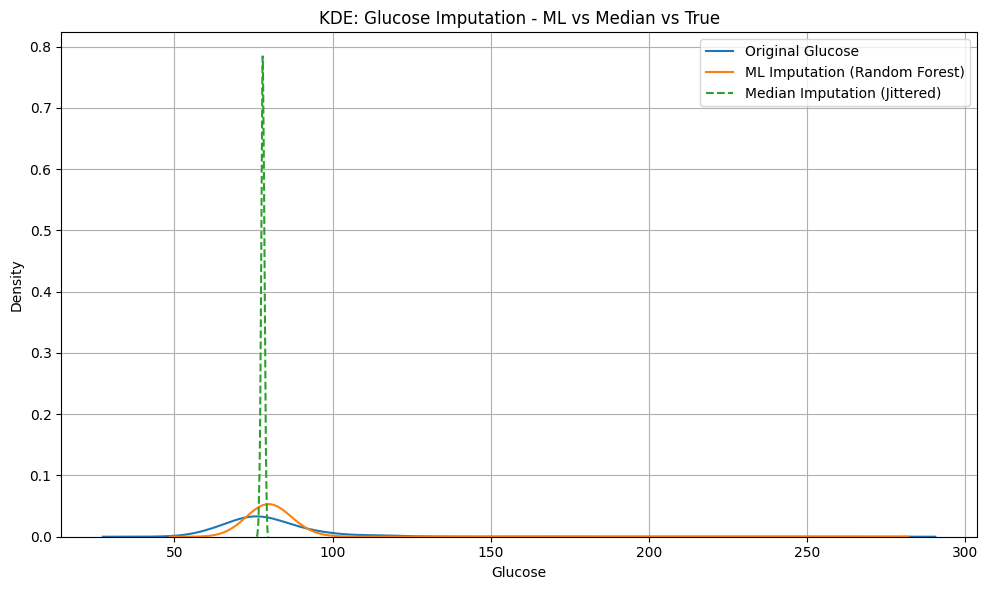

In [16]:
true_values = y_val  # true glucose in validation set
val_preds = pipeline.predict(X_val)
model_preds = val_preds


# Add small jitter to median predictions for visualization
median_glucose = df_known['glucose'].median()  # define the missing variable
median_preds_kde = median_glucose + np.random.normal(0, 0.5, size=len(y_val))
  # very small noise

# KDE plot with jittered median imputation
plt.figure(figsize=(10, 6))
sns.kdeplot(true_values, label='Original Glucose')
sns.kdeplot(model_preds, label='ML Imputation (Random Forest)')
sns.kdeplot(median_preds_kde, label='Median Imputation (Jittered)', linestyle='--')

plt.title("KDE: Glucose Imputation - ML vs Median vs True")
plt.xlabel("Glucose")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Solving class imbalance problem

In [17]:


# Impute remaining missing values (for predictors like 'education', 'BPMeds' etc.)
preprocessor = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(preprocessor.fit_transform(X), columns=X.columns)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Confirm new class distribution
resampled_distribution = pd.Series(y_resampled).value_counts(normalize=True).rename_axis('CHD Risk').reset_index(name='Proportion')
resampled_distribution

,CHD Risk,Proportion
0,0,0.5
1,1,0.5


# Modeling

## Model Selection for Probability-Based Prediction

In this project, our goal is not just to classify whether a patient is at risk for heart disease (binary outcome), but to output a **probability score** indicating the likelihood of risk. This allows for:

- Flexible decision thresholds 
- Risk-tier messaging in the UI 
- Better interpretability and clinical relevance

The following machine learning models were selected because they **support probability outputs via `predict_proba()`**:

| Model                                   | Probability Support | Notes                                                                 |
|----------------------------------------|---------------------|-----------------------------------------------------------------------|
| **Logistic Regression**                | Yes              | Outputs calibrated probabilities directly using a sigmoid function   |
| **Random Forest**                      | Yes              | Aggregates tree probabilities; reasonably well-calibrated            |
| **Gradient Boosting (XGBoost, LightGBM)** | Yes           | Returns probabilities; often benefits from calibration in practice   |
| **MLPClassifier (Neural Network)**     | Yes              | Final layer uses sigmoid/softmax for probabilistic output            |
| **Naive Bayes**                        | Yes              | Computes class-conditional probabilities from feature distributions  |


All these models return probabilities through `predict_proba()`, making them ideal for **threshold-based decision logic** in the CardioAdvisor.ai system.


In [32]:
# Feature groups
categorical_features = ['education', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'currentSmoker', 'male']
numeric_features = ['age', 'cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose', 'sysBP', 'diaBP']

for col in categorical_features:
    X_resampled[col] = X_resampled[col].astype('category')


In [33]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

In [34]:
# Models to compare

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'MLP Classifier': MLPClassifier(max_iter=500, random_state=42),
    'Naive Bayes': GaussianNB()
}


### Logistic Regression

In [40]:
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_scores = cross_val_score(lr_pipe, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("Logistic Regression AUC:", lr_scores)
print("Mean:", round(lr_scores.mean(), 4), "| Std:", round(lr_scores.std(), 4))

Logistic Regression AUC: [0.70993857 0.96816566 0.97584344 0.96966309 0.97074054]
Mean: 0.9189 | Std: 0.1045


### Random Forest

In [45]:
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_scores = cross_val_score(rf_pipe, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("Random Forest AUC:", rf_scores)
print("Mean:", round(rf_scores.mean(), 4), "| Std:", round(rf_scores.std(), 4))

Random Forest AUC: [0.86753883 0.99368239 0.99453827 0.99634402 0.99458953]
Mean: 0.9693 | Std: 0.0509


### MLPClassifier

In [46]:
mlp_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(max_iter=500, random_state=42))
])

mlp_scores = cross_val_score(mlp_pipe, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("MLPClassifier AUC:", mlp_scores)
print("Mean:", round(mlp_scores.mean(), 4), "| Std:", round(mlp_scores.std(), 4))


MLPClassifier AUC: [0.65360068 0.96813476 0.96724705 0.97284515 0.97035753]
Mean: 0.9064 | Std: 0.1264


### Gradient Boosting

In [43]:
gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

gb_scores = cross_val_score(gb_pipe, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("Gradient Boosting AUC Scores:", gb_scores)
print("Mean:", round(gb_scores.mean(), 4), "| Std:", round(gb_scores.std(), 4))

Gradient Boosting AUC Scores: [0.73687123 0.98115342 0.98589932 0.98092603 0.98215823]
Mean: 0.9334 | Std: 0.0983


### Naive Bayes (Failed)

In [44]:
nb_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Disable sparse matrix
    ]), categorical_features)
])

nb_pipe = Pipeline([
    ('preprocessor', nb_preprocessor),
    ('classifier', GaussianNB())
])

nb_scores = cross_val_score(nb_pipe, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("Naive Bayes AUC Scores:", nb_scores)
print("Mean:", round(nb_scores.mean(), 4), "| Std:", round(nb_scores.std(), 4))

Naive Bayes AUC Scores: [0.5 0.5 0.5 0.5 0.5]
Mean: 0.5 | Std: 0.0


In [53]:
print(X_train.columns.tolist())


['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'TenYearCHD']


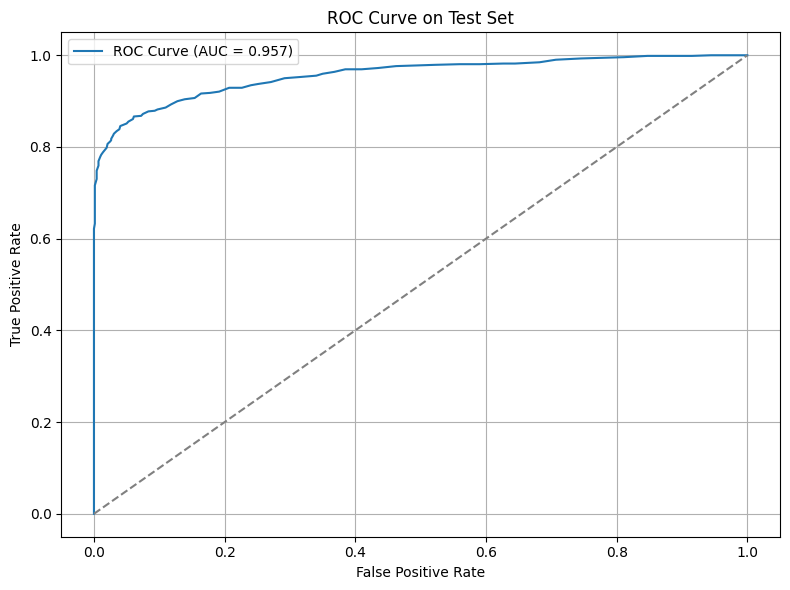

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


best_pipeline.fit(X_train, y_train)

y_prob = best_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

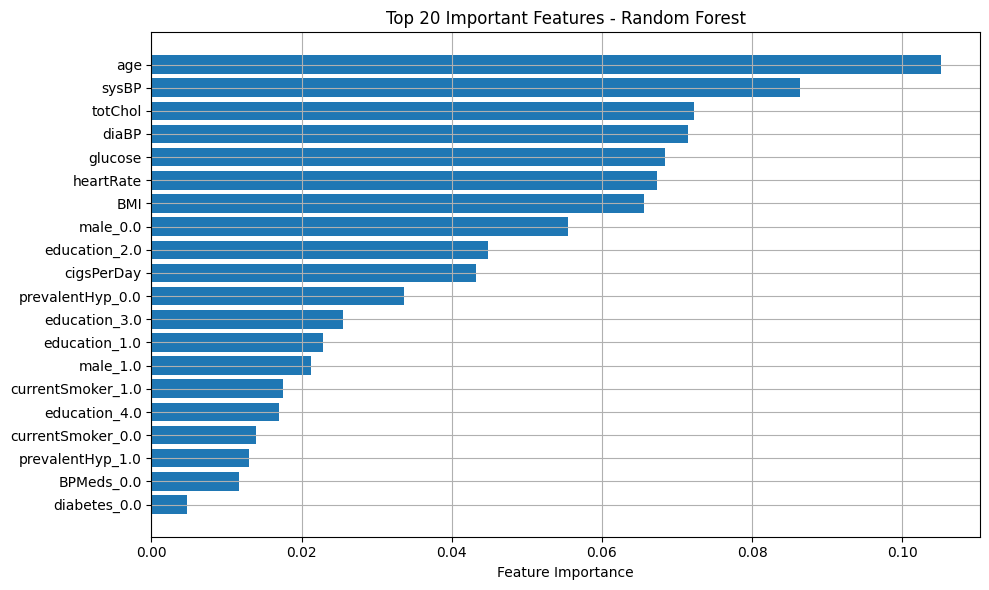

In [58]:
# Get one-hot encoded feature names
encoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = np.concatenate([numeric_features, encoded_cat_features])

importances = best_pipeline.named_steps['classifier'].feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features - Random Forest")
plt.tight_layout()
plt.grid(True)
plt.show()

# Hyperparameter Tuning

In [59]:
# Define parameter grid "
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}


In [60]:
# Grid Search with CV on the full pipeline
grid_search = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [61]:
grid_search.fit(X_resampled, y_resampled)

# Best model
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
y_prob = best_pipeline.predict_proba(X_resampled)[:, 1]

# Evaluation
tuned_results = {
    "Best Parameters": best_params,
    "Cross-Validated AUC": round(grid_search.best_score_, 4),
}
tuned_results

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'Best Parameters': {'classifier__max_depth': 40,
  'classifier__max_features': 'sqrt',
  'classifier__min_samples_leaf': 1,
  'classifier__min_samples_split': 2,
  'classifier__n_estimators': 500},
 'Cross-Validated AUC': 0.9566}

## Save best model

In [62]:
with open('risk_classifier2.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)